<a href="https://colab.research.google.com/github/Jondoloh/Jondoloh-Kernel_Methods_Week_1/blob/main/Kernel_Methods_Practical_Session_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Session 3
## Kernel Methods for Machine Learning

Written by Yunlong Jiao / Romain Menegaux, 20 May 2020


* [Part I - Basics](#part1)
    1. [Generating data](#generating-data)
    2. [SVM scikit-learn implementation](#scikit-implementation)
    3. [Plotting the results](#plotting-margins)
* [Part II - Tuning C](#part2)
    1. [Choosing C by cross-validation](#cross-validation)
    2. [Influence of C on performance](#best-C)
    3. [Interactive Plot](#interactive-plot)
* [Part III - Custom Implementation using Quadratic Programming](#part3)
    1. [Hard Margin](#hard-margin)
       * [Primal](#hard-margin-primal)
       * [Dual](#hard-margin-dual)
       * [Getting w and b from dual solution](#primal-from-dual-hard)
       * [Non separable data](#non-separable)
    2. [Soft Margin](#soft-margin)
       * [Primal](#soft-margin-primal)
       * [Dual](#soft-margin-dual)

In [ ]:
# setup
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
import sys
print(sys.version)

import warnings
warnings.filterwarnings('ignore')

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [ ]:
import sklearn
sklearn.__version__

'1.0.2'

In [ ]:
import sys

solver='cvxopt'
# solver = 'quadprog'

if solver == 'cvxopt':
    try:
        import cvxopt
    except:
        try:
            # If conda install fails for you, try pip install:
            # !{sys.executable} -m pip install cvxopt
            !conda install --yes --prefix {sys.prefix} cvxopt
            import cvxopt
        except:
            raise ImportError('Could not import or conda install cvxopt. You could try installing with pip. Or try solver=quadprog')

if solver == 'quadprog':
    try:
        import quadprog
    except:
        try:
            !conda install --yes --prefix {sys.prefix} -c omnia quadprog
            # If conda install fails for you, try pip install:
            # !{sys.executable} -m pip install quadprog
            import quadprog
        except:
            raise ImportError('Could not import or conda install quadprog. You could try installing with pip. Or try solver=cvxopt')
            
print('Using solver `{}`'.format(solver))

Using solver `cvxopt`


***
## Part I - Basics <a name="part1"></a>

### Generating data <a name="generating-data"></a> 
- **Generate 20 binary classification samples** (10 from each class $y = 1$ and $y = −1$).

Use $\mathbf{x} \in \mathbb{R}^2$, for visualization purpose, where each element $x \sim \mathcal{N}(\mu_y,\sigma^2), \mu_1 = 0, \mu_{-1}=1$.

- **Generate 1000 separate testing samples from the same distribution**
- **Visualize training data.**

In [ ]:
# Simulate data
np.random.seed(54321)
p = 2

def generate_Xy(n_samples, p=2, sigma=.2):

   # X of shape (n_samples, p)
   X = np.random.randn(n_samples,p)*sigma
   X[n_samples//2:] +=1

   # y vector of length n_samples
   y = np.ones(n_samples)
   y[n_samples//2:] =-1
  
   return X, y

# Training data
X_train, y_train = generate_Xy(20)

# Testing data
X_test, y_test = generate_Xy(1000)

In [ ]:
#X_train

In [ ]:
y_train

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.])

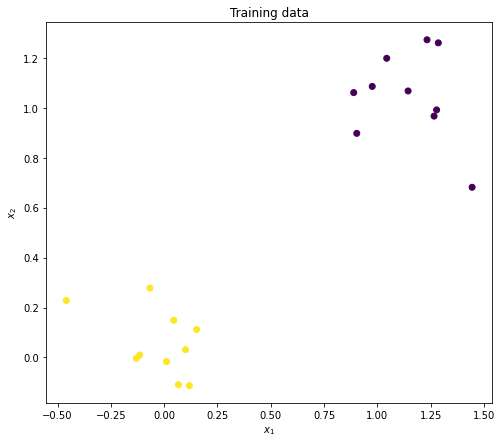

In [ ]:
# Visualize training data
def plot_data(X, y, title=''):
    plt.figure(figsize=(8,7))
    plt.title(title)
    # use plt.scatter to plot data
    plt.scatter(X[:,0],X[:,1],c=y)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()
    
plot_data(X_train, y_train, title='Training data')

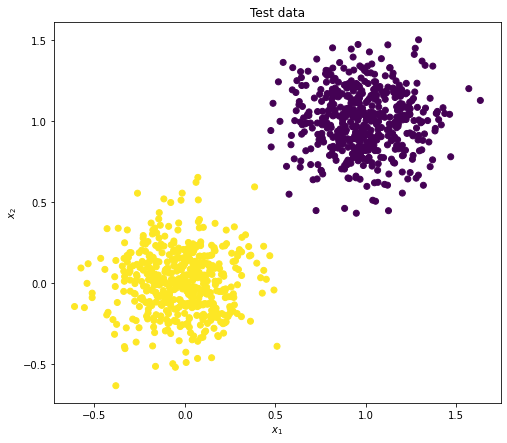

In [ ]:
plot_data(X_test, y_test, title='Test data')

## SVM scikit-learn implementation <a name="scikit-implementation"></a>
**Train a linear SVM** with parameter $C = 10$ on the training set, using the function `sklearn.svm.LinearSVC`. Inspect the resulting object

In [ ]:
from sklearn.svm import LinearSVC

# Parameters
C = 10

# Create the model
clf =LinearSVC(C=C)
# Train the model
clf.fit(X_train, y_train)
clf.__dict__

{'C': 10,
 'class_weight': None,
 'classes_': array([-1.,  1.]),
 'coef_': array([[-1.233112  , -1.12133398]]),
 'dual': True,
 'fit_intercept': True,
 'intercept_': array([1.20639503]),
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'n_features_in_': 2,
 'n_iter_': 111,
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [ ]:
# Prediction error
def error(y_pred, y_true):
    e = (y_pred != y_true).mean()
    return e

In [ ]:
w = clf.coef_[0]
b = clf.intercept_[0]
print('Model parameters:')
print('w: {}'.format(w))
print('b: {}'.format(b))

Model parameters:
w: [-1.233112   -1.12133398]
b: 1.2063950304083337


In [ ]:
# Training error
y_fit = clf.predict(X_train)
err_train = error(y_fit, y_train)
print('Training error = {:.1%}'.format(err_train))

# Testing error
y_pred = clf.predict(X_test)
err_test = error(y_pred, y_test)
print('Testing error = {:.1%}'.format(err_test))

Training error = 0.0%
Testing error = 0.0%


#### Reminder

SVM as a model:
$\hat{y} = sign(w^\top x + b)$

Goal: find the best possible $w$ and $b$
$$$$

**Our implementation of `clf.predict`**:

In [ ]:
w.shape,X_train.shape

((2,), (20, 2))

In [ ]:
# What clf.predict does under the hood:
y_fit = np.sign(w@X_train.T + b)
err_train = error(y_fit, y_train)
print('Training error = {:.1%}'.format(err_train))

Training error = 0.0%


**Why is the error so low?**:

***
### Plot the points and the decision boundaries of a linear SVM <a name="plotting-margins"></a>
Recall: 
the boundary (separating hyperplane) is the set of points for which $f(x) = w^T x + b = 0$.

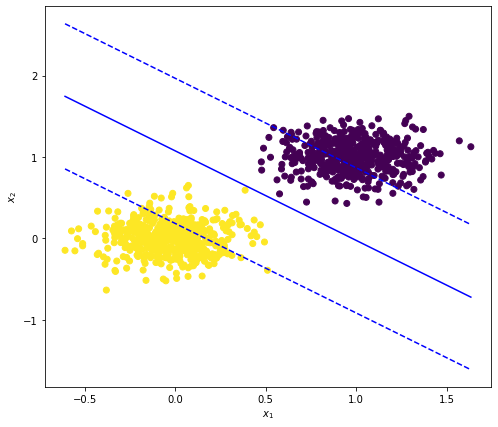

In [ ]:
# Visualize training data and separating hyperplane
def compute_margins(b, w1, w2, x1):
    '''
    returns x2, x2_up, x2_low such that:
        - f(x2) = 0
        - f(x2_up) = 1
        - f(x2_low) = -1
    '''
    x2 = -(b+w1*x1)/w2
    x2_up = (1-(b+w1*x1))/w2
    x2_low = (-1-(b+w1*x1))/w2
    
    return x2, x2_up, x2_low

def plot_points_with_margin(X, y, w, b):
    plt.figure(figsize=(8,7))

    # Training data
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

    # Separating hyperplane and decision boundaries
    x1 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    w1, w2 = w
    x2, x2_up, x2_low = compute_margins(b, w1, w2, x1)

    plt.plot(x1, x2, 'b')
    plt.plot(x1, x2_up, 'b--')
    plt.plot(x1, x2_low, 'b--')

    # Plot
    plt.show()
    
w = clf.coef_[0]
b = clf.intercept_[0]
plot_points_with_margin(X_test, y_test, w, b)

## Part II - Tuning C <a name="part2"></a>
- Try different values of $C$, and visualize the effect of $C$ on the margin and number of support vectors.
- Train a linear SVM with values of $C$ between $10^{−3}$ and $1$. Plot and analyze the training and testing classification errors as a function of $C$. Question: Why can't we overfit more?
- Choose $C$ by cross-validation.

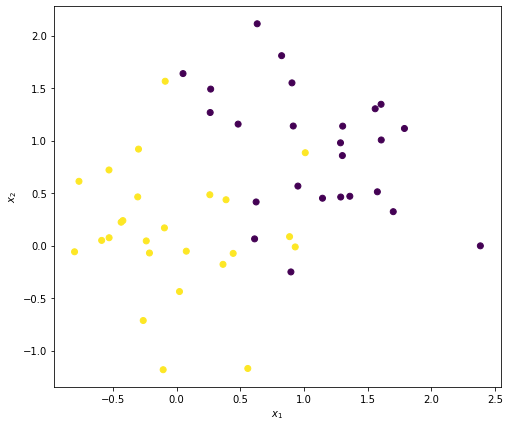

In [ ]:
# Let's make the data less separable
# Training data
X_train2, y_train2 = generate_Xy(50, sigma=.5)
# Testing data
X_test2, y_test2 = generate_Xy(1000, sigma=.5)

plot_data(X_train2, y_train2)

### Choosing C by cross-validation <a name="cross-validation"></a>

Find the best $C$ using cross validation

Results with optimal C
----------------------
Training error = 10.0%
Testing error = 12.2%


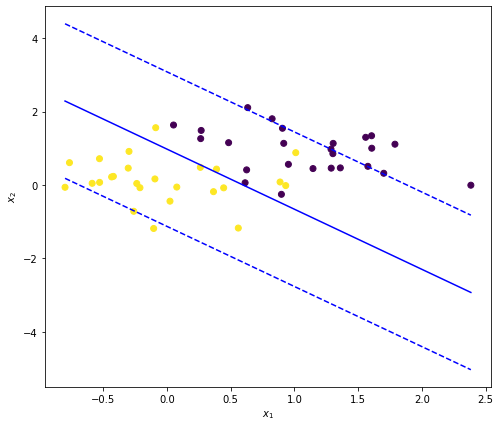

In [ ]:
from sklearn.model_selection import cross_val_score

# Cross validation
C_candidates = 10 ** np.linspace(-3, 2, 100) # Possible values of C we want to test
score_candidates = np.zeros(len(C_candidates)) # Cross-validation scores for each of the Cs

for i, C in enumerate(C_candidates):
    clf = sklearn.svm.LinearSVC(penalty='l2',loss='hinge', C=C)
    scores = cross_val_score(clf, X_train2, y_train2, cv=5, scoring='accuracy')
    score_candidates[i] = scores.mean()
    
# Find the index of the best C:
best_index = np.argmax(score_candidates)
best_C = C_candidates[best_index]

# Training with cross-validated C
clf_best = sklearn.svm.LinearSVC(penalty='l2', loss='hinge', C=best_C)
clf_best.fit(X_train2, y_train2)

print('Results with optimal C')
print('----------------------')
# Training error
y_fit = clf_best.predict(X_train2)
err_train = error(y_fit, y_train2)
print('Training error = {:.1%}'.format(err_train))

# Testing error
y_pred = clf_best.predict(X_test2)
err_test = error(y_pred, y_test2)
print('Testing error = {:.1%}'.format(err_test))

plot_points_with_margin(X_train2, y_train2, clf_best.coef_[0], clf_best.intercept_[0])

### Influence of $C$ on performance <a name="best-C"></a>

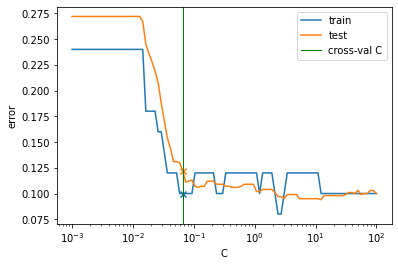

In [ ]:
# Train-test error curve
err_train = np.zeros(len(C_candidates))
err_test = np.zeros(len(C_candidates))

# OPTIONAL
# We also store the model coefficients to plot the decision boundaries
b = np.zeros_like(C_candidates)
w = np.zeros((len(C_candidates), p))

for i, C in enumerate(C_candidates):
    # print('C = ', C)
    clf = sklearn.svm.LinearSVC(penalty='l2',loss='hinge',C=C)
    clf.fit(X_train2, y_train2)
    
    # Store model coefs
    b[i] = clf.intercept_[0]
    w[i] = clf.coef_[0]

    # Training error
    y_fit = clf.predict(X_train2)
    err_train[i] = error(y_fit, y_train2)
    # print('Training error = ', err_train[i])
    
    # Testing error
    y_pred = clf.predict(X_test2)
    err_test[i] = error(y_pred, y_test2)
    # print('Testing error = ', err_test[i])

# Plot training and testing error as a function of C
plt.figure()
plt.plot(C_candidates, err_train, label='train')
plt.xscale('log')
plt.plot(C_candidates, err_test, label='test')
plt.axvline(best_C, linewidth=1, color='g', label='cross-val C')
plt.legend()
plt.scatter(best_C, err_train[best_index], marker='x', label='train')
plt.scatter(best_C, err_test[best_index], marker='x', label='test')
plt.xlabel('C')
plt.ylabel('error')
plt.show()

### Interactive plot <a name="interactive-plot"></a>

This cell requires the packages [bqplot](https://github.com/bqplot/bqplot) and [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/user_install.html) to be installed. (See installation instructions, then refresh the page)

In [ ]:
# # Experimental (not guaranteed to work for everyone):

# # Conda installation from the notebook: un-comment the following 2 lines:
# # !conda install --yes --prefix {sys.prefix} -c conda-forge bqplot
# # !conda install --yes --prefix {sys.prefix} ipywidgets

# # If conda install fails for you, try pip install, un-comment the following 3 lines:
# !{sys.executable} -m pip install bqplot
# !jupyter nbextension enable --py --prefix {sys.prefix} bqplot
# !{sys.executable} -m pip install ipywidgets

In [ ]:
import bqplot.pyplot as bqp
from ipywidgets import IntSlider, HTML, HBox, VBox

x1 = np.linspace(X_test2[:,0].min(), X_test2[:,0].max(), 100)

slider_C = IntSlider(min=0, max=len(CL)-1, value=len(CL)/2,
                     description='Choose C:', readout=False)
readout = HTML()
fig = bqp.figure(min_aspect_ratio=1.1, max_aspect_ratio=1.1,
           layout={'min_width': '500px', 'min_height': '500px'})
scat = bqp.scatter(X_test2[::2, 0], X_test2[::2, 1],
                   colors=['orange' if y == 1 else 'purple' for y in y_test2[::2]],
                   default_size=40, opacities=[0.7])
                   #axes_options={'color': None})
sep = bqp.plot(x1, np.zeros_like(x1), preserve_domain={'x': True, 'y': True})
margin_up = bqp.plot(x1, np.zeros_like(x1), '--', preserve_domain={'x': True, 'y': True})
margin_down = bqp.plot(x1, np.zeros_like(x1), '--', preserve_domain={'x': True, 'y': True})


def update_margins(*args):
    i = slider_C.value
    sep.y, margin_up.y, margin_down.y = compute_margins(b[i], w[i, 0], w[i, 1], sep.x)
    readout.value = 'C = {:.3f}'.format(CL[i])

slider_C.observe(update_margins)
update_margins()

#bqp.show()
VBox([fig, HBox([slider_C, readout])])

NameError: ignored

***
## Part III - Custom SVM implementation with quadratic programming<a name="part3"></a>
We will use a quadratic program (QP) solver `cvxopt` to find our own solution to SVM

```
cvxopt.solvers.qp(P, q[, G, h[, A, b]])
```
solves the quadratic program

$$
\begin{aligned}
\min_x & \, \frac{1}{2}x^\top P x + q^\top x \\
\mathrm{s.t. } \, & Gx \leq h \\
& Ax = b
\end{aligned}
$$

- $P, q$ define the objective
- $G, h$ are all the inequality constraints
- $A, b$ are all the equality constraints

**Goal: Find $P$, $q$, $G$, $h$, $A$ and $b$ for SVM**
***

In [ ]:
# You don't need to look at this, this is just to adapt our matrices
# to the solver being used

def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -np.vstack([A, G]).T
        qp_b = -np.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = - G.T
        qp_b = - h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

def cvxopt_qp(P, q, G, h, A, b):
    P = .5 * (P + P.T)
    cvx_matrices = [
        cvxopt.matrix(M) if M is not None else None for M in [P, q, G, h, A, b] 
    ]
    solution = cvxopt.solvers.qp(*cvx_matrices)
    return np.array(solution['x']).flatten()

solve_qp = {'quadprog': quadprog_solve_qp, 'cvxopt': cvxopt_qp}[solver]

### Hard Margin SVM <a name="hard-margin"></a>
(See slide 83)

### Primal problem (hard margin) <a name="hard-margin-primal"></a>
$$
\begin{aligned}
\min_{w, b} & \, \frac{1}{2}w^\top w \\
\mathrm{s.t. } \, & y_i x_i^\top w + y_i b \geq 1 \,\,\,, \forall i \in [1, n]\\
\end{aligned}
$$

First step: what is $x$ in our case, with the slides notations?

$x = (w_1,\cdots,w_n,b)$

***
**We set $X_y = \mathrm{diag}(y)X = (y_1x_1, ..., y_nx_n)^\top \in \mathbb{R}^{n\times p}$**

$X_y$ is simply $X$ with its rows $i$ multiplied by $y_i$

### Hard margin SVM

**Primal**
$$
\begin{aligned}
\min_{w, b} & \, \frac{1}{2}w^\top w \\
\mathrm{s.t. } \, & y_i x_i^\top w + y_i b \geq 1\\
\end{aligned}
$$

<font color='red'> Watch out for the signs in the constraints! </font>

### Let's implement it!

In [ ]:
def svm_primal_hard_to_qp(X, y):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Primal formulation, hard margin
    diag_P = np.zeros(p + 1) # correct this!
    diag_P[:-1] +=1
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    diag_P += eps
    P = np.diag(diag_P)
    
    q = np.zeros(p+1)
    G = - np.hstack([Xy,y[:,None]])
    h = - np.zeros(n)
    A = None
    b = None
    
    return P, q, G, h, A, b

x = solve_qp(*svm_primal_hard_to_qp(X_train, y_train))
n, p = X_train.shape
w, b = x[:-1], x[-1]

In [ ]:
plot_points_with_margin(X_train, y_train, w, b)

#### Dual: <a name="hard-margin-dual"></a>
$$
\begin{aligned}
\max_\alpha & \, \mathrm{1}^\top\alpha - \frac{1}{2}\alpha^\top X_y X_y^\top \alpha \\
\mathrm{s.t. } \, & \alpha \geq 0 \\
& y^\top\alpha = 0
\\
\end{aligned}
$$

You can verify that:
$$
L(\alpha) =  -\frac{1}{2}\sum_{i, j} \alpha_i \alpha_j x_i^\top x_j y_i y_j + \sum_i \alpha_i = -\frac{1}{2} \alpha^\top X_y X_y^\top \alpha + \mathbf{1}^\top\alpha
$$

Then implement it below:

In [ ]:
def svm_dual_hard_to_qp(X, y):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Dual formulation, hard margin
    P = Xy@Xy.T

    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    P += eps * np.eye(n)
    
    q = -np.ones(n)
    G = -np.eye(n)
    h = np.zeros(n)
    A = y.reshape(1,-1)

    b =np.zeros((1,1))

    return P, q, G, h, A, b

alphas = solve_qp(*svm_dual_hard_to_qp(X_train, y_train))

### How do we find $w$ and $b$ from $\alpha$? $$$$<a name="primal-from-dual-hard"></a>
$$$$

Answer is in slide 82

In [ ]:
def get_primal_from_dual(alpha, X, y, hard_margin=False, C=None, tol=1e-3):
    # w parameter in vectorized form
    w = (alpha * y)@X
    
    # sv = Support vectors!
    # Indices of points (support vectors) that lie exactly on the margin
    # Filter out points with alpha == 0
    sv = np.where((alpha>tol))[0][0]
    # If soft margin, also filter out points with alpha == C
    if not hard_margin:
        if C is None:
            raise ValueError('C must be defined in soft margin mode')
        sv = np.logical_and(sv,sv)
    b = y[sv]-w.dot(X[sv])
    
    #Display results
    print('Alphas = {}'.format(alpha[sv]))
    print('Number of support vectors = {}'.format(sv.sum()))
    print('w = {}'.format(w))
    print('b = {}'.format(b))
    
    return w, b

w, b = get_primal_from_dual(alphas, X_train, y_train, hard_margin=True)
plot_points_with_margin(X_train, y_train, w, b)

#### Does not work if data is not linearly separable! <a name="non-separable"></a>

In [ ]:
X_non_separable, y_non_separable = generate_Xy(20, sigma=2)
solve_qp(*svm_primal_hard_to_qp(X_non_separable, y_non_separable))

### Soft margin SVM <a name="soft-margin"></a>
(slides 89, 91)

### Primal (soft margin): <a name="soft-margin-primal"></a>
$$
\begin{aligned}
\min_{w, b, \xi} & \, \frac{1}{2}w^\top w + C \mathbf{1}^\top \xi \\
\mathrm{s.t. } \, & \xi \geq 0 \\
& y_i x_i^\top w + y_i b + \xi_i\geq 1
\\
\end{aligned}
$$

In [ ]:
def svm_primal_soft_to_qp(X, y, C=1):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Primal formulation, soft margin
    diag_P = 
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    diag_P += eps
    P = np.diag(diag_P)
    
    q = 
    G =
    h =
    A = None
    b = None
    return P, q, G, h, A, b

coefs = solve_qp(*svm_primal_soft_to_qp(X_train, y_train, C=C))
n, p = X_train.shape
w, b, e = coefs[:p], coefs[p], coefs[(p+1):]


In [ ]:
plot_points_with_margin(X_train, y_train, w, b)

### Dual (soft margin): <a name="soft-margin-dual"></a>
$$
\begin{aligned}
\max_\alpha & \, \mathrm{1}^\top\alpha -\frac{1}{2}\alpha^\top X_y^T X_y \alpha \\
\mathrm{s.t. } \, & \alpha \geq 0 \\
& \alpha \leq C \\
& y^\top\alpha = 0
\\
\end{aligned}
$$

In [ ]:
def svm_dual_soft_to_qp(X, y, C=1):
    n, p = X.shape
    assert (len(y) == n)
    
    Xy = np.diag(y).dot(X)
    # Dual formulation, soft margin
    P =
    # As a regularization, we add epsilon * identity to P
    eps = 1e-12
    P += eps * np.eye(n)
    q =
    G =
    h =
    A =
    b =
    return P, q, G, h, A, b

C = 10
alphas = solve_qp(*svm_dual_soft_to_qp(X_train, y_train, C=C))


#### Finding $w$ and $b$ from $\alpha$ $$$$<a name="primal-from-dual-soft"></a>
$$$$

Answer is in slide 92

In [ ]:
w, b = get_primal_from_dual(alphas, X_train, y_train, C=C)
plot_points_with_margin(X_train, y_train, w, b)